## Import necessary libraries

In [1]:
%%capture captured
!pip install matplotlib rouge

In [4]:
if captured.stderr != '':
    captured.show()
else:
    print('All requirements are satisfied')

All requirements are satisfied


In [5]:
import os, requests 

from tqdm.auto import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer


/opt/anaconda3/envs/llmcamp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the data

In [6]:
github_url = "https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv"
url = f'{github_url}?raw=1'

df = pd.read_csv(url)
df = df.iloc[:300]
df.shape

(300, 5)

In [7]:
df.head()

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## Q1: Getting the embeddings model

In [8]:
%%time

model_name = 'multi-qa-mpnet-base-dot-v1'
embedding_model = SentenceTransformer(model_name)

CPU times: user 1.23 s, sys: 593 ms, total: 1.82 s
Wall time: 2.14 s


In [9]:
answer_llm = df.iloc[0].answer_llm
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [10]:
vector = embedding_model.encode(answer_llm)
type(vector)

numpy.ndarray

In [11]:
vector[0:5]

array([-0.42244682, -0.22485572, -0.32405868, -0.28475893,  0.00725704],
      dtype=float32)

## Q2: Computing the dot product

In [12]:
%%time

similarities = []

for _, row in tqdm(df.iterrows(), desc='creating pairs of vectors'):
    
    answer_llm_vector = embedding_model.encode(row.answer_llm)
    answer_orig_vector = embedding_model.encode(row.answer_orig)

    dot_product = np.dot(answer_llm_vector, answer_orig_vector)
    similarities.append(dot_product)


creating pairs of vectors: 300it [00:37,  7.94it/s]

CPU times: user 2min 51s, sys: 1min 9s, total: 4min 1s
Wall time: 37.8 s


In [13]:
p75 = np.percentile(similarities, 75)
print('p75 point: ', p75)

p75 point:  31.674302101135254


<Axes: >

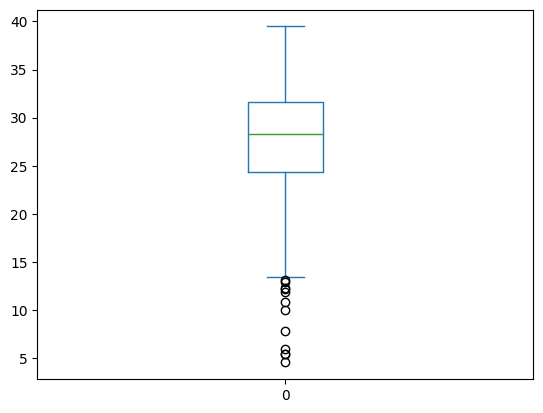

In [14]:
pd.DataFrame(similarities).plot(kind='box')

## Q3: Computing the cosine

In [15]:
%%time

# Let's normalize the embeddings for bounding the similarity scores

def normalize_vector(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm


cosine_similarities = []

for _, row in tqdm(df.iterrows(), desc='creating pairs of vectors'):
    
    answer_llm_vector = normalize_vector(embedding_model.encode(row.answer_llm))
    answer_orig_vector = normalize_vector(embedding_model.encode(row.answer_orig))

    dot_product = np.dot(answer_llm_vector, answer_orig_vector)
    cosine_similarities.append(dot_product)

creating pairs of vectors: 300it [00:09, 30.29it/s]

CPU times: user 41 s, sys: 23.2 s, total: 1min 4s
Wall time: 9.93 s


In [16]:
p75 = np.percentile(cosine_similarities, 75)
print('p75 point: ', p75)

p75 point:  0.8362346738576889


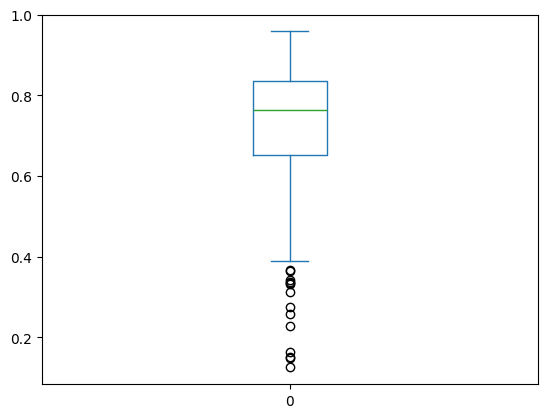

In [17]:
pd.DataFrame(cosine_similarities).plot(kind='box');

## Q4: Rouge

In [20]:
row = df.loc[10]
row

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
Name: 10, dtype: object

In [21]:
from rouge import Rouge

rouge_scorer = Rouge()
scores = rouge_scorer.get_scores( row.answer_llm, row.answer_orig )

In [26]:
scores

[{'rouge-1': {'r': 0.45454545454545453,
   'p': 0.45454545454545453,
   'f': 0.45454544954545456},
  'rouge-2': {'r': 0.21621621621621623,
   'p': 0.21621621621621623,
   'f': 0.21621621121621637},
  'rouge-l': {'r': 0.3939393939393939,
   'p': 0.3939393939393939,
   'f': 0.393939388939394}}]

In [27]:
# isolate the asked value

scores[0]['rouge-1']['f']

0.45454544954545456

## Q5: Average rouge score

In [28]:
val = scores[0]['rouge-1']['f'] + scores[0]['rouge-2']['f'] + scores[0]['rouge-l']['f']
print(val / 3)

0.35490034990035496


## Q6: Average rouge score for all the data points

In [31]:
def rouge2_pandas(row):

    return rouge_scorer.get_scores( row.answer_llm, row.answer_orig )[0]['rouge-2']['f']

df['q6'] = df.apply(lambda x: rouge2_pandas(x), axis=1)

In [33]:
df['q6'].mean()

0.20696501983423318

## That's a wrap